In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean=0.5 and std=0.5
])

# Download and load the training data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Download and load the test data
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Example: Display the size of the training set
print(f"Number of training samples: {len(train_dataset)}")


Number of training samples: 60000


In [70]:
print(f"Number of test samples: {len(test_dataset)}")

Number of test samples: 10000


In [4]:

print("Original labels (before noise):", train_dataset.targets[:10].tolist())

# Function to add label noise by shuffling labels
def add_label_noise(dataset, noise_fraction):
    """
    Adds label noise by shuffling labels for a fraction of the dataset.

    Args:
        dataset: A PyTorch dataset object (e.g., MNIST).
        noise_fraction: Fraction of data to corrupt (0 <= noise_fraction <= 1).

    Returns:
        The dataset with shuffled labels for the specified fraction.
    """
    # Total number of samples
    num_samples = len(dataset)
    
    # Number of labels to corrupt
    num_noisy_labels = int(noise_fraction * num_samples)
    
    # Get the indices to shuffle
    indices = np.random.choice(num_samples, num_noisy_labels, replace=False)
    
    # Shuffle the labels
    noisy_targets = dataset.targets.clone()  # Clone the targets to avoid modifying the original directly
    noisy_targets[indices] = torch.randint(0, 10, size=(num_noisy_labels,))  # Random labels in the range [0, 9]
    
    # Update the dataset's targets
    dataset.targets = noisy_targets
    return dataset



Original labels (before noise): [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [5]:
def get_model_parameters_vector(model):
    # Concatenate all parameters into a single vector
    return torch.cat([p.view(-1) for p in model.parameters()])


In [6]:
subset_size = 10000  # Use only 10,000 samples
train_dataset = add_label_noise(train_dataset, noise_fraction=0.3)
indices = np.random.choice(len(train_dataset), subset_size, replace=False)  # Randomly select indices
train_subset = Subset(train_dataset, indices)


# Create data loaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [58]:
class DeepNN(nn.Module):
    def __init__(self):
        super(DeepNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),  # First layer with 512 neurons
            nn.ReLU(),
            #nn.Dropout(0.3),       # Dropout for regularization
            nn.Linear(512, 256),   # Second layer with 256 neurons
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(256, 128),   # Third layer with 128 neurons
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(128, 64),    # Fourth layer with 64 neurons
            nn.ReLU(),
            nn.Linear(64, 10)      # Output layer for 10 classes
        )
    
    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        return self.model(x)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepNN().to(device)
criterion = nn.CrossEntropyLoss()

# Define optimizers
# Add Full Gradient Descent optimizer to the dictionary

optimizers = {
    'SGD': optim.SGD(model.parameters(), lr=0.001, momentum=0),
    'Adam': optim.Adam(model.parameters(), lr=0.001),
    'RMSprop': optim.RMSprop(model.parameters(), lr=0.001)
}
# Dictionary to store test losses for each optimizer
training_losses = {opt_name: [] for opt_name in optimizers.keys()}
test_losses = {opt_name: [] for opt_name in optimizers.keys()}
test_accuracies = {opt_name: [] for opt_name in optimizers.keys()}
parameter_vectors = {opt_name: [] for opt_name in optimizers.keys()}
# Dictionary to store gradient norms for each optimizer
gradient_norms = {opt_name: [] for opt_name in optimizers.keys()}

def train_model(optimizer_name, optimizer, num_epochs=300):
    print(f"\nTraining with {optimizer_name}...")
    model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
    optimizer = optimizer
    
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        epoch_gradient_norm_sum = 0.0  # Initialize gradient norm sum for this epoch

        num_batches = len(train_loader)
        
        # Mini-batch Gradient Descent
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            
            # for sgd 
            if optimizer_name == 'SGD':
                all_grads = []
                for param in model.parameters():
                    if param.grad is not None:
                        # Compute the update
                        update = param.grad
                        all_grads.append(param.grad.view(-1))
                        # Optional: Log or store the update
                        #print(f"Update: {update.norm(2).item()}")  # Log L2 norm of the update
                all_grads = torch.cat(all_grads)
                epoch_gradient_norm_sum += all_grads.norm(2).item()

                # Iterate over model parameters to collect gradients
            #     for param in model.parameters():
            #         if param.grad is not None:
            #             #print("params norm grad", param.grad.norm(2))
                        
            #             # Flatten the gradient and append it to the list
            #             all_grads.append(param.grad.view(-1))

            # # Concatenate all gradients into a single tensor (1D vector)
            #     all_grads = torch.cat(all_grads)
                
            # # Compute the L2 norm of the concatenated gradients
            #     epoch_gradient_norm_sum += all_grads.norm(2).item()
            
            if optimizer_name == 'RMSprop':
            # Initialize a list to collect all the updates
                all_updates = []

                # # Loop over model parameters to apply RMSProp updates
                for param in model.parameters():
                    if param.grad is not None:
                        #print("params norm grad", param.grad.norm(2))
                        if param in optimizer.state:  # Ensure the parameter exists in optimizer state
                            s_t = optimizer.state[param].get('square_avg', None)  # Access 'square_avg' safely
                            
                            if s_t is not None:
                    
                                # Compute the update using RMSProp formula: divide gradient by sqrt(s_t)
                                update = param.grad * torch.sqrt(s_t + 1e-07)  # RMSProp update (with sqrt(s_t) and epsilon)
                                #print(update)
                            else:
                                print("b")
                                # Handle case where 'square_avg' does not exist in optimizer state (fallback)
                                update = param.grad  # Just use the gradient if no 'square_avg' is found

                        else:
                            print("c")
                            # If parameter not in optimizer state, just use the gradient
                            update = param.grad
                        
                        # Accumulate the updates
                        all_updates.append(update.view(-1))  # Flatten and collect updates

                # Concatenate all updates into a single tensor (1D vector)
                #all_updates = torch.cat(all_updates)
                                

                # # Compute the L2 norm of the concatenated updates (total update norm)
                # epoch_gradient_norm_sum += all_updates.norm(2).item()  # L2 norm of all updates
                # for param in model.parameters():
                #     if param.grad is not None:
                #         # Check if the parameter is in the optimizer's state
                #         if param in optimizer.state:
                #             # Extract the moving average of squared gradients (s_t)
                #             s_t = optimizer.state[param].get('square_avg', None)
                #             if s_t is not None:
                #                 # Compute the RMSProp update
                #                 update = param.grad / torch.sqrt(s_t + 1e-7)
                #                 print("-----------grad----------------")
                #                 print(param.grad)
                #                 print("----------momentum-------------")
                #                 print(torch.sqrt(s_t + 1e-7))
                #                 print("--------------update---------")
                #                 print(update)
                #                 print(f"RMSProp Update for parameter: {update.norm(2).item()}")
                #                 all_updates.append(update.view(-1))
                all_updates = torch.cat(all_updates)
                epoch_gradient_norm_sum += all_updates.norm(2).item()
                                

            
            optimizer.step()
            
            # Accumulate metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
    
        # Log gradient norms for this epoch
        gradient_norms[optimizer_name].append(epoch_gradient_norm_sum/num_batches)

        # Calculate training metrics
        train_accuracy = 100 * correct_train / total_train
        train_loss = running_loss / (1 if optimizer_name == 'FullGD' else len(train_loader))
        training_losses[optimizer_name].append(train_loss)  # Record training loss
        
        # Evaluate the model on the test set
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        test_loss /= len(test_loader)
        test_accuracy = 100 * correct_test / total_test
        test_losses[optimizer_name].append(test_loss)  # Record test loss
        test_accuracies[optimizer_name].append(test_accuracy)  # Record test accuracy
        param_vector = get_model_parameters_vector(model).cpu().detach().numpy()
        parameter_vectors[optimizer_name].append(param_vector)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Training Loss: {train_loss:.4f}, "
              f"Training Accuracy: {train_accuracy:.2f}%, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Accuracy: {test_accuracy:.2f}%, "
              f"Gradient Norm Sum: {epoch_gradient_norm_sum:.4f}")

initial_model_state = model.state_dict()

# Define a function to reset the model to its initial state
def reset_model_to_initial_state(model, initial_state):
    model.load_state_dict(initial_state)

# Train the model with each optimizer
for opt_name, opt in optimizers.items():
    # Step 2: Reset the model to its initial state
    reset_model_to_initial_state(model, initial_model_state)
    # Step 3: Train the model
    train_model(opt_name, opt)





Training with SGD...
Epoch [1/300], Training Loss: 2.3056, Training Accuracy: 9.80%, Test Loss: 2.3048, Test Accuracy: 9.68%, Gradient Norm Sum: 33.3602
Epoch [2/300], Training Loss: 2.3047, Training Accuracy: 9.84%, Test Loss: 2.3035, Test Accuracy: 9.72%, Gradient Norm Sum: 33.5755
Epoch [3/300], Training Loss: 2.3036, Training Accuracy: 9.90%, Test Loss: 2.3021, Test Accuracy: 9.89%, Gradient Norm Sum: 33.1445
Epoch [4/300], Training Loss: 2.3027, Training Accuracy: 10.07%, Test Loss: 2.3008, Test Accuracy: 10.05%, Gradient Norm Sum: 33.8359
Epoch [5/300], Training Loss: 2.3018, Training Accuracy: 10.25%, Test Loss: 2.2994, Test Accuracy: 10.40%, Gradient Norm Sum: 33.1385
Epoch [6/300], Training Loss: 2.3007, Training Accuracy: 10.43%, Test Loss: 2.2981, Test Accuracy: 10.90%, Gradient Norm Sum: 33.7133
Epoch [7/300], Training Loss: 2.2999, Training Accuracy: 10.95%, Test Loss: 2.2969, Test Accuracy: 11.56%, Gradient Norm Sum: 33.4998
Epoch [8/300], Training Loss: 2.2989, Training

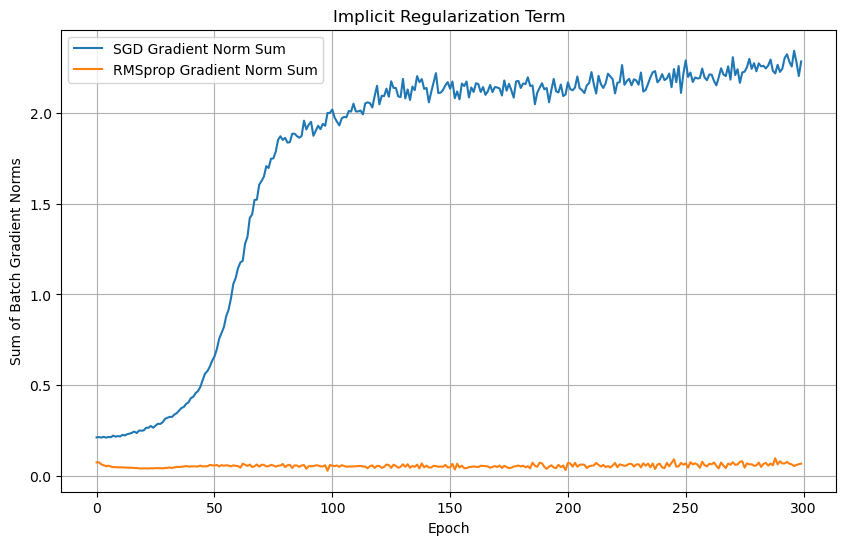

In [69]:
plt.figure(figsize=(10, 6))
for opt_name, norms in gradient_norms.items():
    if opt_name == "Adam":  # Skip the specific optimization technique
        continue
    plt.plot(norms, label=f'{opt_name} Gradient Norm Sum')
plt.title('Implicit Regularization Term')
plt.xlabel('Epoch')
plt.ylabel('Sum of Batch Gradient Norms')
plt.legend()
#plt.ylim((0,0.5))
plt.grid(True)
plt.show()

In [47]:
for opt_name, norms in gradient_norms.items():
    print(opt_name)
    print(norms)

SGD
[0.19722036485839042, 0.21296963266506316, 0.23234110909282782, 0.2834215709927735, 0.36913597450894153, 0.5389435653853568, 0.8172339844475885, 1.260413047614371, 1.8360001122116283, 2.0291202391029164]
Adam
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSprop
[1592.7616547655127, 1.0804544411107282, 20.22557692599904, 11.885376913679147, 0.19173894555806212, 0.004653348743168127, 0.0045982249804837685, 0.004323700379141292, 0.004538343946455391, 0.004639794222512253]


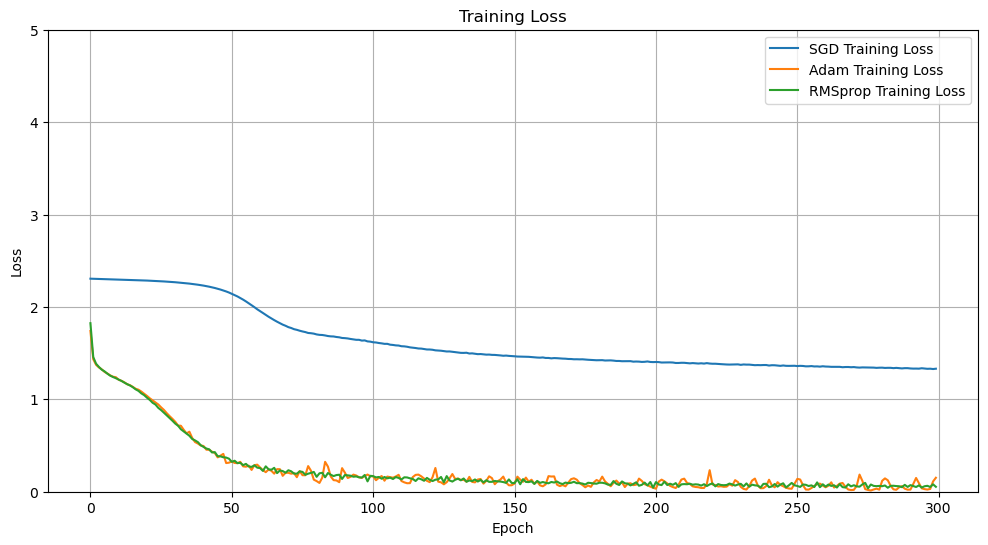

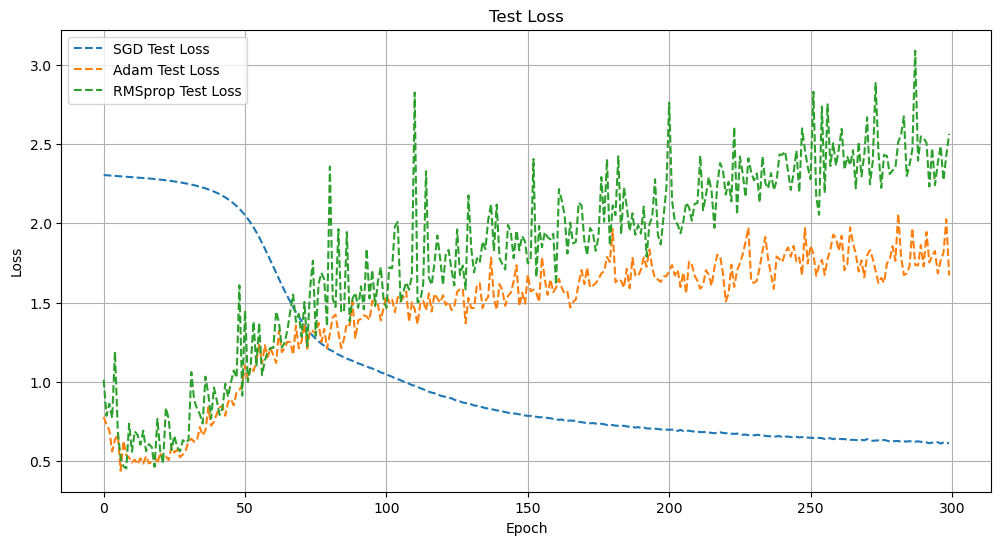

In [65]:
# Plot training losses
plt.figure(figsize=(12, 6))
for opt_name, losses in training_losses.items():
    plt.plot(losses, label=f'{opt_name} Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim((0,5))
plt.grid(True)
plt.show()

# Plot test losses
plt.figure(figsize=(12, 6))
for opt_name, losses in test_losses.items():
    plt.plot(losses, linestyle='--', label=f'{opt_name} Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim((0,5))
plt.legend()
plt.grid(True)
plt.show()


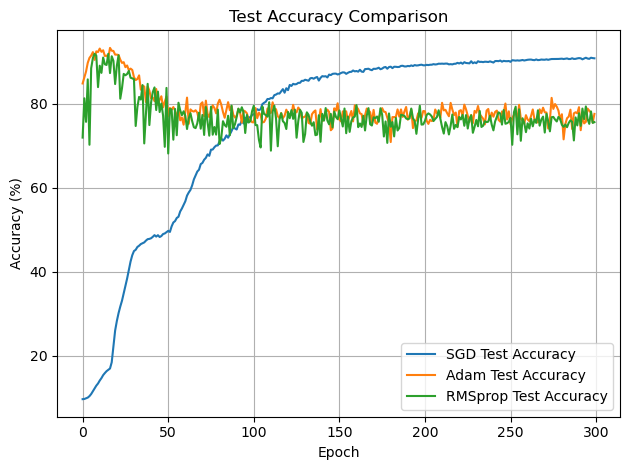

In [61]:

for opt_name, accs in test_accuracies.items():
    plt.plot(accs, label=f'{opt_name} Test Accuracy')
plt.title('Test Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


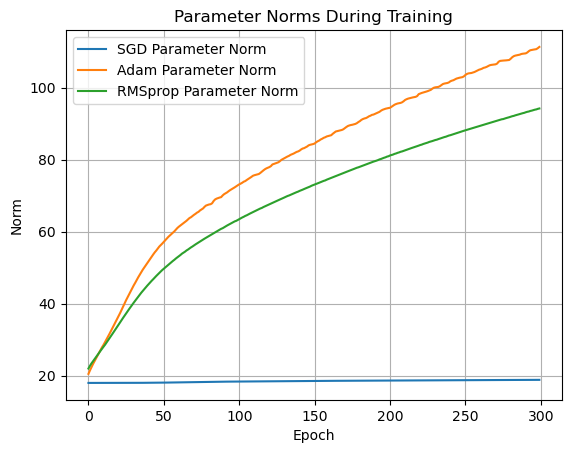

In [62]:


for opt_name, vectors in parameter_vectors.items():
    norms = [np.linalg.norm(vec) for vec in vectors]
    plt.plot(norms, label=f'{opt_name} Parameter Norm')

plt.title('Parameter Norms During Training')
plt.xlabel('Epoch')
plt.ylabel('Norm')
plt.legend()
plt.grid(True)
plt.show()


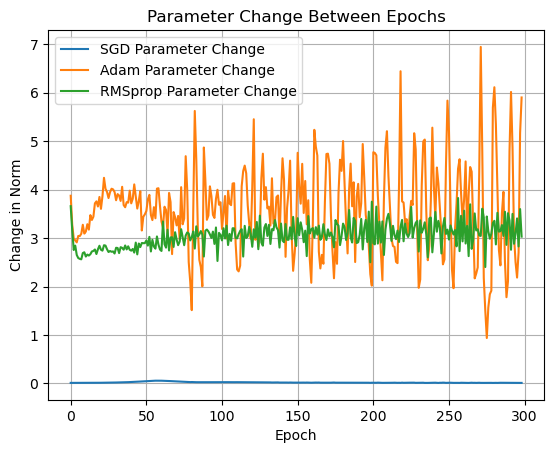

In [63]:
for opt_name, vectors in parameter_vectors.items():
    changes = [np.linalg.norm(vectors[i+1] - vectors[i]) for i in range(len(vectors)-1)]
    plt.plot(changes, label=f'{opt_name} Parameter Change')

plt.title('Parameter Change Between Epochs')
plt.xlabel('Epoch')
plt.ylabel('Change in Norm')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
for opt_name, vectors in parameter_vectors.items():
    norms = [np.linalg.norm(vec) for vec in vectors]
    print(opt_name)
    print(norms)


SGD
[18.001862, 18.005358, 18.012291, 18.024956, 18.048346, 18.08878, 18.15024, 18.236128, 18.310778, 18.353342]
Adam
[48.253204, 50.539257, 51.83009, 52.894512, 54.147316, 55.33731, 56.52069, 57.437416, 58.26949, 58.934467]
RMSprop
[73.65625, 74.43401, 75.154854, 75.91562, 75.98133, 75.98141, 75.98121, 75.981285, 75.981255, 75.98107]


In [43]:
# Get model summary
model_config = []
for idx, layer in enumerate(model.model):
    model_config.append(f"Layer {idx+1}: {layer}")

# Combine into a neat string
model_summary = "\n".join(model_config)
print("Model Configuration:")
print(model_summary)


Model Configuration:
Layer 1: Linear(in_features=784, out_features=512, bias=True)
Layer 2: ReLU()
Layer 3: Linear(in_features=512, out_features=256, bias=True)
Layer 4: ReLU()
Layer 5: Linear(in_features=256, out_features=128, bias=True)
Layer 6: ReLU()
Layer 7: Linear(in_features=128, out_features=64, bias=True)
Layer 8: ReLU()
Layer 9: Linear(in_features=64, out_features=10, bias=True)


In [44]:
total_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters: {total_params}")

Total number of parameters: 575050
